In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

#SMOTE
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as make_pipeline_imb 
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from collections import Counter
#Evaluation
from sklearn import metrics
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
df = pd.read_csv('C:/Users/user/Desktop/프로젝트 data/최적입지_변수_총합(용산적용전)3.csv',
                 encoding='euckr')


In [3]:
df.head()

,id,bus,metro,taxi,uni,high,park,cf,bike,pop,class
0,27900,0.75,0.00,0.0,0.0,0.00,0.0,0.0,0.0,1.5,1
1,27896,0.75,0.25,0.0,0.0,0.00,0.0,0.0,0.0,1.5,1
2,27894,2.50,0.00,0.0,0.0,0.75,0.0,0.0,0.0,1.5,1
3,27739,0.75,0.00,0.0,0.0,0.25,0.0,0.0,0.0,1.5,1
4,27597,0.75,0.00,0.0,0.0,0.25,0.0,0.0,2.5,1.5,1


In [4]:
# 타겟값 확인

,class,Value Count,Percentage
0,0,12275,0.782994
1,1,3402,0.217006


<AxesSubplot:xlabel='class'>

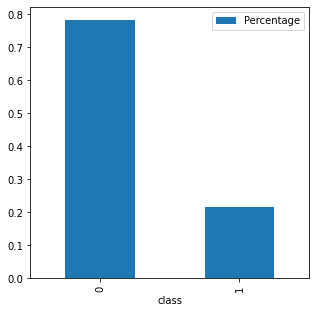

In [5]:
def val_count_df(df, column_name, sort=True):
    value_count = df[column_name].value_counts(sort=sort).reset_index().rename(columns={column_name:"Value Count","index":column_name}).set_index(column_name)
    value_count["Percentage"] = df[column_name].value_counts(sort=sort,normalize=True)
    value_count = value_count.reset_index()
    value_count = value_count.style.format({'Percentage': "{:.2%}"})
    return value_count.data

target_count = val_count_df(df, "class")
display(target_count)
target_count.set_index("class").plot.bar(y="Percentage", figsize=(5,5), legend='Percentage')

In [6]:
def exploreDataset(df):
    df_copy = df.copy()
    print("The dataset contains {} rows with {} N/A values".format(df_copy.shape[0], df_copy.isna().sum()))
    print("Number of rows:", df_copy.shape[0], "Number of Cols:", df_copy.shape[1])
    numericFeatures = df_copy.select_dtypes(include = np.number).columns
    print("Numeric Features from dataset are :",numericFeatures)
    categoricalFeatures = df_copy.select_dtypes(include = object).columns
    print("Categorial Features from dataset are :",categoricalFeatures)
    
exploreDataset(df)

The dataset contains 15677 rows with id       0
bus      0
metro    0
taxi     0
uni      0
high     0
park     0
cf       0
bike     0
pop      0
class    0
dtype: int64 N/A values
Number of rows: 15677 Number of Cols: 11
Numeric Features from dataset are : Index(['id', 'bus', 'metro', 'taxi', 'uni', 'high', 'park', 'cf', 'bike',
       'pop', 'class'],
      dtype='object')
Categorial Features from dataset are : Index([], dtype='object')


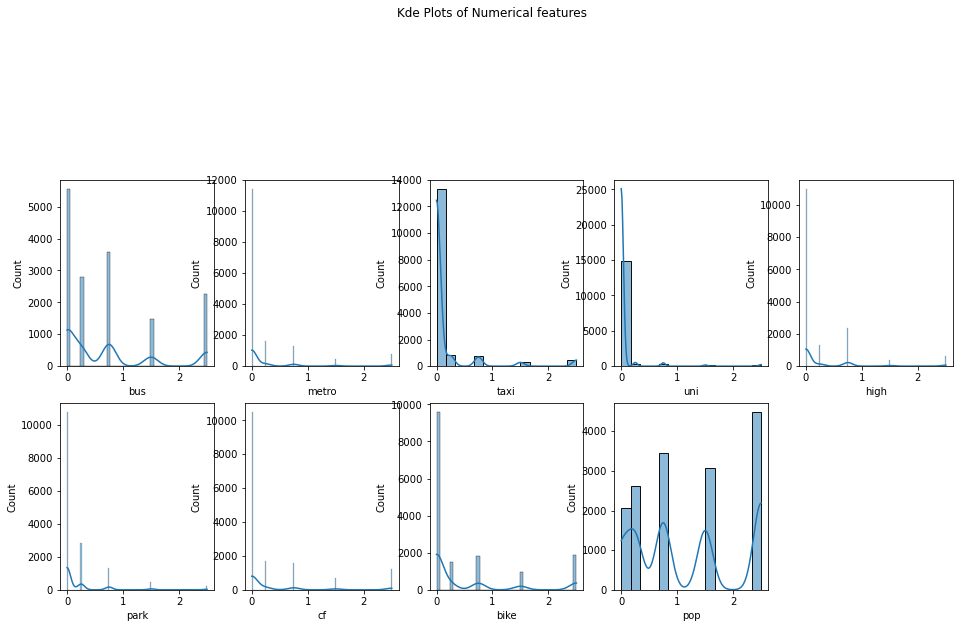

In [7]:
import seaborn as sns
param = ['bus', 'metro', 'taxi', 'uni', 
        'high', 'park', 'cf', 'bike', 'pop']
plt.figure(figsize=(16,24))
numRange= [i for i in range(1,10)]
for i in numRange:
    plt.subplot(6,5,i,aspect='auto')
    sns.histplot(data=df,x=param[i-1], kde=True)
plt.suptitle('Kde Plots of Numerical features')
plt.show()

In [8]:
def drawCorrelationMatrix(df):
    
    cmap = sns.diverging_palette(250, 15, s=75, l=40,
                                 n=9, center="light", as_cmap=True)
    matrix = df.corr()
    mask = np.triu(np.ones_like(matrix, dtype=bool))
    plt.figure(figsize=(16,12))
    plt.title("Correlation heatmap between all parameters")
    fig = sns.heatmap(matrix, mask=mask, center=0, annot=True,
                 fmt='.1f', square=True, cmap=cmap)
    
def getRedundantPairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def getTopAbsCorrelations(df, n=5,method = 'pearson'):
#   ''' Get top 5 most correlated features in the given dataset. Method can be 'pearson', 'spearman', 'kendall' ''''
    au_corr = df.corr(method = method).abs().unstack()
    labels_to_drop = getRedundantPairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    print("Top {} Correlated features in given dataset".format(n))
    return au_corr[0:n]

Top 5 Correlated features in given dataset


metro  bike     0.397905
bike   class    0.368424
bus    class    0.340731
metro  taxi     0.309548
bus    bike     0.301743
dtype: float64

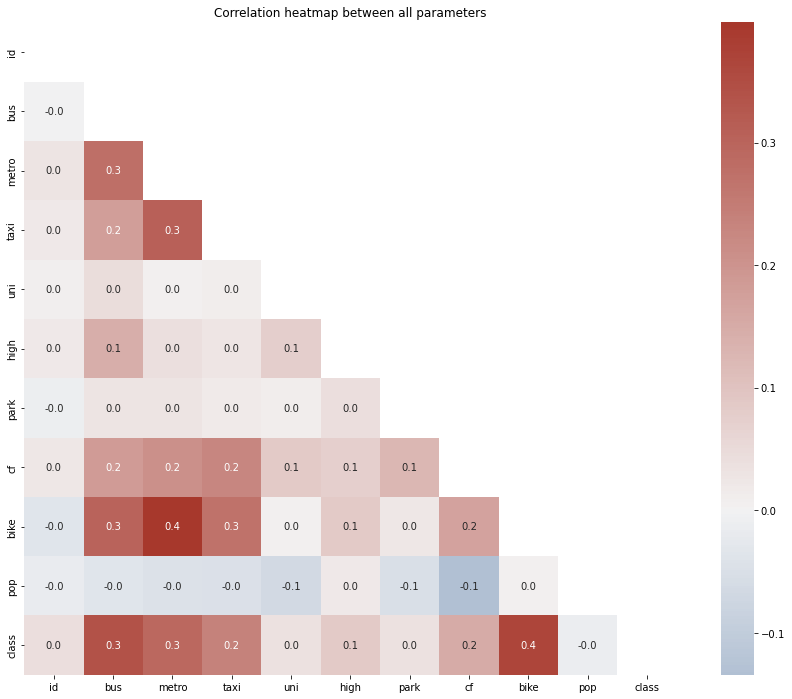

In [9]:
drawCorrelationMatrix(df)
getTopAbsCorrelations(df)

In [10]:
# import model and matrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import f1_score
# split dataset into x,y
x = df.drop('class',axis=1)
y = df['class']
# train-test split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=13)

In [11]:
def cfMatrix(df):
    ax = sns.heatmap(df, annot=True, cmap='Blues')
    ax.set_title('Seaborn Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

Confusion Matrix: 
[[3387  318]
 [ 654  345]]
Accuracy Score: 0.7933673469387755
Area Under Curve: 0.6297576929155876
Recall score: 0.34534534534534533


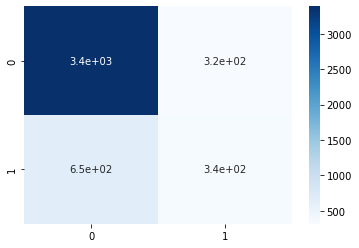

In [12]:
# define model
lg1 = LogisticRegression(random_state=13, class_weight=None,solver='lbfgs', max_iter=1000)
# fit it
lg1.fit(X_train,y_train)
# test
y_pred = lg1.predict(X_test)
# performance
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')

ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues')

print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')
print(f'Recall score: {recall_score(y_test,y_pred)}')

# 가중 로지스틱 회귀 분석 -
### 데이터 세트에서 레이블 분포는 1:99이므로 가중치를 레이블 분포의 역순으로 지정할 수 있다. 다수석은 1의 가중치를 사용하고 소수석은 99의 가중치를 사용한다.

Confusion Matrix: 

[[2043 1662]
 [  83  916]]


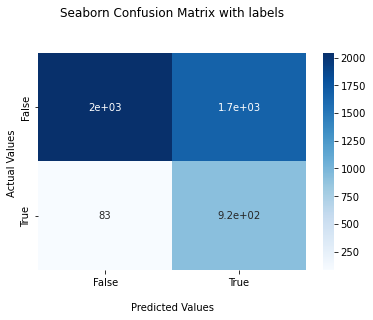

Accuracy Score: 0.6290391156462585
Area Under Curve: 0.7341669604827501
Recall score: 0.9169169169169169


In [13]:
# define class weights
w = {0:12, 1:88}
# define model
lg2 = LogisticRegression(random_state=13, class_weight=w,max_iter=1000)
# fit it
lg2.fit(X_train,y_train)
# test
y_pred = lg2.predict(X_test)
# performance
df2 = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix: \n')
print(df2)
cfMatrix(df2)
print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')

print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')
print(f'Recall score: {recall_score(y_test,y_pred)}')

## Grid Search/halfingGrid Search를 통해 최적화된 가중치

In [14]:
w = [{0:100,1:1000},{0:10,1:1000}, {0:0,1:1.1000}, 
     {0:1.0,1:500}, {0:1.0,1:400}, {0:1.0,1:300}, {0:1.0,1:200}, 
     {0:1.0,1:150}, {0:1.0,1:100}, {0:1.0,1:99}, {0:1.0,1:10}]
hyperparam_grid = {"class_weight": w }

# define model
lg3 = LogisticRegression(random_state=13,max_iter = 2000)
# define evaluation procedure
halving_cv = HalvingGridSearchCV(
    lg3, hyperparam_grid, scoring="roc_auc", n_jobs=-1, 
    min_resources="exhaust", factor=3
)
# grid = RandomizedSearchCV(lg3,hyperparam_grid,scoring="roc_auc", cv=100, n_jobs=-1, refit=True)
halving_cv.fit(x,y)
print(f'Best score: {halving_cv.best_score_} with param: {halving_cv.best_params_}')

Best score: 0.7965011766398764 with param: {'class_weight': {0: 1.0, 1: 10}}


Confusion Matrix: 

[[1382 2323]
 [  25  974]]


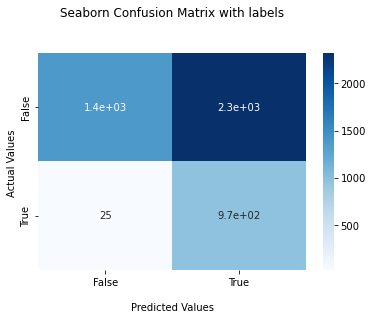

Accuracy Score: 0.5008503401360545
Area Under Curve: 0.6739922108343162
Recall score: 0.974974974974975


In [15]:
# Best score: 0.7967468029919662 with param: {'class_weight': {0: 1.0, 1: 10}}
lg3 = LogisticRegression(random_state=13, class_weight={0: 1.0, 1: 10},max_iter = 1000)
# fit it
lg3.fit(X_train,y_train)
# test
y_pred = lg3.predict(X_test)
# performance
df3 = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix: \n')
print(df3)
cfMatrix(df3)
print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')
print(f'Recall score: {recall_score(y_test,y_pred)}')

###### 

In [16]:
lg4 = LogisticRegression(random_state=13,C=13.0,fit_intercept=True, 
                         penalty='l2',class_weight={0: 1.0, 1: 10} )
# fit it
lg4.fit(X_train,y_train)
# test
y_pred = lg4.predict(X_test)
# performance
print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}') # 0.5
print(f'Recall score: {recall_score(y_test,y_pred)}')

Accuracy Score: 0.501062925170068
Confusion Matrix: 
[[1383 2322]
 [  25  974]]
Area Under Curve: 0.6741271636008478
Recall score: 0.974974974974975


## Resampling

In [17]:
cols = X_train.columns

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train,columns=cols)
X_test = pd.DataFrame(X_test,columns=cols)

In [18]:
train_data=pd.concat([X_train,y_train],axis=1)

Response_Zero=train_data[train_data['class']==0]
Response_One=train_data[train_data['class']==1]

In [19]:
#For Sampling
from sklearn.utils import resample
upsampled_One = resample(Response_One,
                          replace=True, # sample with replacement
                          n_samples=len(Response_Zero), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([Response_Zero, upsampled_One])
upsampled.dropna(inplace = True)

In [20]:
upsampled

,id,bus,metro,taxi,uni,high,park,cf,bike,pop,class
996,-0.707427,2.072227,-0.016071,-0.316622,-0.175508,0.820025,0.119416,-0.507727,-0.596567,0.295511,0.0
997,0.242146,-0.837525,-0.430032,-0.316622,-0.175508,-0.479157,-0.448327,-0.507727,-0.596567,-1.029965,0.0
998,-1.068178,2.072227,-0.430032,-0.316622,-0.175508,0.820025,-0.448327,-0.507727,1.201739,-0.499775,0.0
999,-0.325209,-0.837525,-0.430032,-0.316622,-0.175508,-0.479157,-0.448327,-0.507727,-0.596567,1.355893,0.0
1003,-1.265420,-0.837525,-0.430032,-0.316622,-0.175508,-0.479157,1.254902,-0.507727,0.302586,0.295511,0.0
...,...,...,...,...,...,...,...,...,...,...,...
3021,1.800394,2.072227,0.811851,-0.316622,-0.175508,-0.046096,1.254902,2.933253,1.201739,0.295511,1.0
986,0.823866,0.908326,-0.430032,-0.316622,-0.175508,-0.479157,-0.448327,2.933253,-0.596567,1.355893,1.0
8185,0.924908,-0.837525,-0.430032,-0.316622,-0.175508,-0.479157,-0.448327,-0.507727,-0.596567,-0.499775,1.0
3954,-1.063497,2.072227,-0.430032,-0.316622,-0.175508,-0.479157,-0.448327,-0.507727,1.201739,0.295511,1.0


,class,Value Count,Percentage
0,1.0,6535,0.529064
1,0.0,5817,0.470936


<AxesSubplot:xlabel='class'>

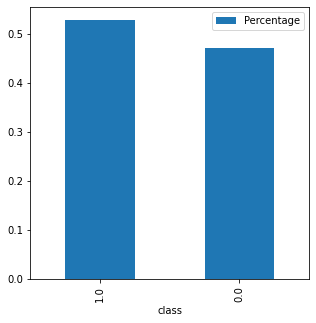

In [21]:
target_count = val_count_df(upsampled, "class")
display(target_count)
target_count.set_index("class").plot.bar(y="Percentage", figsize=(5,5), legend='Percentage')

In [22]:
x = upsampled.drop('class',axis=1)
y = upsampled['class']
# train-test split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=13)

lg4 = LogisticRegression(random_state=13, max_iter = 1000)
# fit it

lg4.fit(X_train,y_train)
# test
y_pred = lg4.predict(X_test)
# performance
print(f'Accuracy Score: {accuracy_score(y_test,y_pred)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}') # 0.5
print(f'Recall score: {recall_score(y_test,y_pred)}')

Accuracy Score: 0.521046950890448
Confusion Matrix: 
[[ 138 1644]
 [ 131 1793]]
Area Under Curve: 0.5046768796768797
Recall score: 0.931912681912682


## SMOTE 

In [23]:
lg5 = LogisticRegression(random_state=13,class_weight={0:89, 1: 21})
smote_pipeline = make_pipeline_imb(SMOTE(random_state=4), lg5)

In [24]:
x = df.drop('class',axis=1)
y = df['class']
# train-test split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=13)
smote_model = smote_pipeline.fit(X_train, y_train)

In [25]:
smote_prediction = smote_model.predict(X_test)

In [26]:
print("normal data distribution: {}".format(Counter(y)))
X_smote, y_smote = SMOTE().fit_resample(x, y)

print("SMOTE data distribution: {}".format(Counter(y_smote)))

normal data distribution: Counter({0: 12275, 1: 3402})
SMOTE data distribution: Counter({1: 12275, 0: 12275})


In [27]:
print(f'Accuracy Score: {accuracy_score(y_test,smote_prediction)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, smote_prediction)}')
print(f'Area Under Curve: {roc_auc_score(y_test, smote_prediction)}') # 0.5
print(f'Recall score: {recall_score(y_test,smote_prediction)}')

Accuracy Score: 0.7971938775510204
Confusion Matrix: 
[[3442  263]
 [ 691  308]]
Area Under Curve: 0.6186615765563134
Recall score: 0.3083083083083083


## 오버샘플링 후 모델 적용

In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from sklearn.model_selection import KFold

In [32]:
# train_test data split
data = ['bus', 'metro', 'taxi', 'uni', 
        'high', 'park', 'cf', 'bike', 'pop']

X_train, X_test, y_train, y_test = train_test_split(
    X_smote[data], # 문제
    y_smote, # 정답
    test_size = 0.3, # test-size비율
    random_state = 200 # 시드값 설정
)

In [35]:
df_clf = DecisionTreeClassifier(random_state=11)
rf_clf = RandomForestClassifier(random_state=11)
svc_clf = SVC()
clf_list = [df_clf, rf_clf, svc_clf]

In [40]:
def exec_kfold(df, clf, k):
    acc_list = []
    kfold = KFold(n_splits=k)
    for i, (train_index, test_index) in enumerate(kfold.split(df[data])):
        X_train2,X_test2 = X_smote[data].values[train_index], df[data].values[test_index]
        y_train2,y_test2 = y_smote.values[train_index],y_smote.values[test_index]
        
        clf.fit(X_train2, y_train2)
        pred2 = clf.predict(X_test2)
        acc = accuracy_score(y_test2, pred2)
        acc_list.append(acc)
        print(i , ': 교차검증 정확도>> {0:.2f}'.format(acc))
    print('평균 정확도>> {0:.2f}'.format(np.mean(acc_list)))
    return np.mean(acc_list)

In [41]:
acc_total = []
model_list = ['decision tree', 'random forest', 'svm']
for i, clf in enumerate(clf_list):
    print(model_list[i], '----검증시작----')
    acc_result = exec_kfold(X_smote, clf, 10)
    acc_total.append(acc_result)

decision tree ----검증시작----
0 : 교차검증 정확도>> 0.62
1 : 교차검증 정확도>> 0.79
2 : 교차검증 정확도>> 0.74
3 : 교차검증 정확도>> 0.82
4 : 교차검증 정확도>> 0.78
5 : 교차검증 정확도>> 0.73
6 : 교차검증 정확도>> 0.95
7 : 교차검증 정확도>> 0.97
8 : 교차검증 정확도>> 0.98
9 : 교차검증 정확도>> 0.98
평균 정확도>> 0.84
random forest ----검증시작----
0 : 교차검증 정확도>> 0.65
1 : 교차검증 정확도>> 0.80
2 : 교차검증 정확도>> 0.76
3 : 교차검증 정확도>> 0.82
4 : 교차검증 정확도>> 0.81
5 : 교차검증 정확도>> 0.75
6 : 교차검증 정확도>> 0.96
7 : 교차검증 정확도>> 0.99
8 : 교차검증 정확도>> 0.99
9 : 교차검증 정확도>> 0.99
평균 정확도>> 0.85
svm ----검증시작----
0 : 교차검증 정확도>> 0.75
1 : 교차검증 정확도>> 0.73
2 : 교차검증 정확도>> 0.62
3 : 교차검증 정확도>> 0.74
4 : 교차검증 정확도>> 0.76
5 : 교차검증 정확도>> 0.60
6 : 교차검증 정확도>> 0.86
7 : 교차검증 정확도>> 0.83
8 : 교차검증 정확도>> 0.82
9 : 교차검증 정확도>> 0.84
평균 정확도>> 0.75


In [42]:
for i in range(3):
    print(model_list[i], " 교차검증 평균: ", acc_total[i])

decision tree  교차검증 평균:  0.8361303462321793
random forest  교차검증 평균:  0.8526272912423625
svm  교차검증 평균:  0.7548676171079429


In [43]:
# 최대 평균값 ==
max_value = np.max(acc_total)
# 최대 평균값 인덱스 ==
max_index = np.argmax(acc_total)
# 최대 평균값 모델명 ==
max_model = model_list[max_index]

print('최고 교차 검증 평균>> ', max_value)
print('최고 교차 검증 인덱스>> ', max_index)
print('최고 교차 검증 모델링>> ', max_model)

최고 교차 검증 평균>>  0.8526272912423625
최고 교차 검증 인덱스>>  1
최고 교차 검증 모델링>>  random forest


In [44]:
def add_value_label(x_list,y_list):
    for i in range(1, len(x_list)+1):
        plt.text(i-1,y_list[i-1],y_list[i-1], 
                 fontsize=15,
                 color="blue",
                 ha="center")

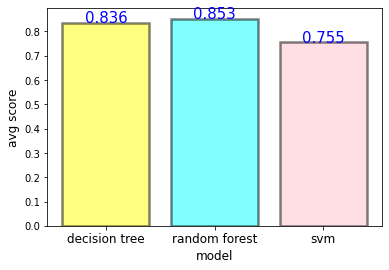

In [45]:
plt.bar(np.arange(len(acc_total)), 
        acc_total,color = ['yellow', 'cyan', 'pink'], alpha = 0.5,
        edgecolor = 'black', linewidth = 2.5)
plt.xticks(np.arange(len(acc_total)), model_list, fontsize=12)
plt.xlabel('model', fontsize=12)
plt.ylabel('avg score', fontsize=12)
add_value_label(model_list, np.round(acc_total, 3))
plt.show()